# Part 1: Hands-On Activity

**Activity**: End-to-end Workflow on Titanic Dataset

**Mode**: Class Walkthrough

**🎯 Goal**: We will apply a Supervised Learning workflow on the famous Titanic dataset to predict the survival of passengers.

**🗒️ Scenario**

The Titanic dataset contains information about the passengers, which includes their age, sex, ticket class, and whether they survived the sinking of the Titanic. Refer to the description and data dictionary: https://www.kaggle.com/competitions/titanic/data

**⚡ Task**

## 1. Imports and Data Loading

First, we import the necessary libraries. seaborn is used here specifically to easily load the built-in Titanic dataset. We then inspect the dataframe to understand its structure and check for missing values, which determines our preprocessing strategy.

In [500]:
import pandas as pd
import seaborn as sns

In [ ]:
# Load the Titanic dataset from the seaborn library
titanic = sns.load_dataset('titanic')
titanic.shape

(891, 15)

In [502]:
# Display the first 5 rows to inspect data types and example values
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [503]:
# Check the distribution of the target variable to see if classes are balanced
titanic.survived.value_counts()

survived
0    549
1    342
Name: count, dtype: int64

In [504]:
# Identify columns with missing values to decide on imputation strategies
# Note: 'age' and 'deck' have significant missing data

titanic.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [505]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

## 2. Feature Selection and Splitting

We select a specific subset of features to train our model. We separate the data into the feature matrix (X) and the target vector (y).

In [506]:
# Select features: mixture of numerical (age, fare) and categorical (sex, embaked)
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
target = 'survived'

# Split data into Features (X) and Target (y)
X = titanic[features]
y = titanic[target]


## 3. Building the Pre-Processing Pipeline

This is the core of the workflow. We use Pipeline to chain sequential steps (like imputation and scaling) and ColumnTransformer to apply these different pipelines to specific columns (numerical vs. categorical) simultaneously.

- **Numerical Data**: We fill missing values with the median and scale data to unit variance.

- **Categorical Data**: We fill missing values with the most frequent value and convert text categories into binary vectors (One-Hot Encoding).

`sklearn`'s pipeline is a tool that allows us to assemble several steps together. It sequentially applies a list of transforms and a final estimator. Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit.

![Pipeline Overview](../assets/titanic-data-pipeline.png)

In [507]:
# 1. Define pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Fill missing values with median
    ('scaler', StandardScaler())                   # Standardize features (mean=0, variance=1)
])

# 2. Define pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Fill missing with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    # Convert categories to binary vectors
])

# 3. Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # Apply numerical pipeline to specific numeric columns
        ('num', numerical_transformer, ['age', 'sibsp', 'parch', 'fare']),
        # Apply categorical pipeline to specific categorical columns
        ('cat', categorical_transformer, ['pclass', 'sex', 'embarked'])
    ])

# 4. Create the full end-to-end pipeline including the model
# This ensures raw data flows through preprocessing directly into the model
model = LogisticRegression()
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)
                          ])

## 4. Training and Evaluation

Finally, we split the data into training and testing sets. We fit the entire pipeline on the training data and evaluate its performance on the unseen test data using various classification metrics.

In [ ]:
# Split data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

# Calculate classification metrics
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

# Calculate ROC curve and AUC score
# Note: We use predict_proba for ROC/AUC to get probability scores instead of class labels
fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Output results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f"AUC: {roc_auc:.2f}")

Accuracy: 0.80
Precision: 0.75
Recall: 0.74
F1 Score: 0.74
AUC: 0.87


## Exercise (Self-Study)

> Now, recreate the workflow but use min-max scaling for numerical features and KNN classifier for model.

We redefine the numerical pipeline to use `MinMaxScaler` instead of `StandardScaler`. We then integrate this into a new preprocessor and combine it with a KNeighborsClassifier.

In [509]:
from sklearn.neighbors import KNeighborsClassifier

# 1. Redefine numerical pipeline with Min-Max Scaling
# Min-Max scaling scales data to a fixed range [0, 1], which preserves the shape of the original distribution
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Fill missing values
    ('scaler', MinMaxScaler())                     # Scale to range [0, 1]
])

# 2. Update the ColumnTransformer
# We reuse the 'categorical_transformer' defined in the previous section (Imputer + OneHotEncoder)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, ['age', 'sibsp', 'parch', 'fare']),
        ('cat', categorical_transformer, ['pclass', 'sex', 'embarked'])
    ])

# 3. Define the new model: K-Nearest Neighbors
model = KNeighborsClassifier()

# 4. Create the new pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)
                          ])


**Training and Evaluation**

We fit this new pipeline to the same training data used previously and evaluate its performance. This allows for a direct comparison between the Logistic Regression (StandardScaler) approach and this KNN (MinMaxScaler) approach.

In [510]:

# Train the KNN pipeline
pipeline.fit(X_train, y_train)

# Generate predictions
preds = pipeline.predict(X_test)

# Calculate classification metrics
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

# Calculate ROC/AUC
# Note: KNN supports predict_proba, which allows us to calculate AUC just like Logistic Regression
fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

In [511]:
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f"AUC: {roc_auc:.2f}")

Accuracy: 0.81
Precision: 0.79
Recall: 0.70
F1 Score: 0.74
AUC: 0.85


# Part 2: Bias-Variance Tradeoff

The Bias-Variance Tradeoff describes the tension between two sources of error that prevent supervised learning algorithms from generalizing beyond their training set:

**Bias (Underfitting)**: Error introduced by approximating a real-world problem, which may be complex, by a much simpler model. High bias can cause an algorithm to miss the relevant relations between features and target outputs (e.g., Degree 1).

**Variance (Overfitting**): Error introduced by the model's sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data rather than the intended outputs (e.g., Degree 15).

Our goal is to find the "sweet spot" where total error is minimized. Strategies to achieve this include tuning model complexity (as seen below), increasing training data, or using regularization.

In [512]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# --- Data Generation ---
np.random.seed(0)
n_samples = 30

In [513]:
# We test three degrees to illustrate the tradeoff:
# Degree 1: High Bias (Underfitting)
# Degree 4: Balanced (Good Generalization)
# Degree 15: High Variance (Overfitting)
degrees = [1, 4, 15] 

X = np.sort(np.random.rand(n_samples))
y = np.cos(1.5 * np.pi * X) + np.random.randn(n_samples) * 0.1

X = X[:, np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

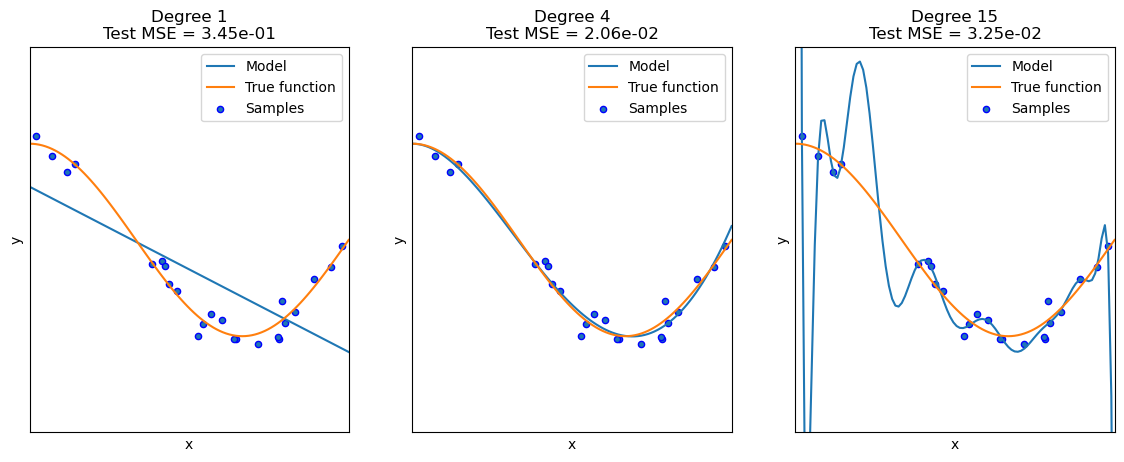

In [514]:
# --- Visualization of the Tradeoff ---
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    # Create pipeline: Polynomial features increase complexity, Linear Regression fits it
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = make_pipeline(polynomial_features, linear_regression)
    
    pipeline.fit(X_train, y_train)

    # Evaluate: High error on test set can indicate either high bias or high variance
    scores = mean_squared_error(pipeline.predict(X_test), y_test)

    X_plot = np.linspace(0, 1, 100)
    plt.plot(X_plot, pipeline.predict(X_plot[:, np.newaxis]), label="Model")
    plt.plot(X_plot, np.cos(1.5 * np.pi * X_plot), label="True function")
    plt.scatter(X_train, y_train, edgecolor='b', s=20, label="Samples")
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    
    # Title shows the MSE. Note: High Variance models often show low training error but high test MSE.
    plt.title("Degree {}\nTest MSE = {:.2e}".format(degrees[i], scores))

plt.show()

In the plots above, you will see that the model with degree 1 has high bias and low variance, the model with degree 15 has low bias and high variance, and the model with degree 4 is trying to balance both.

## What is Bias?

Bias refers to the error that is introduced by approximating a real-world problem, which may be complex, by a simplified model. In other words, it's the difference between the expected prediction of our model and the true values. High bias can cause the model to miss relevant relations between features and target outputs (also known as underfitting).

**Examples of High Bias:**
- Linear regression on non-linear data
- Assuming simplicity when the data has a more complex structure

## What is Variance?

Variance refers to the error that is introduced by the model's sensitivity to the fluctuations in the training dataset. A model with high variance pays a lot of attention to training data and does not generalize on the data which it hasn't seen before (also known as overfitting).

**Examples of High Variance:**
- Fitting a high-degree polynomial to data with lots of fluctuations
- A complex decision tree that creates a branch for each data point

> We will learn more about decision tree in the next unit

## The Tradeoff

The bias-variance tradeoff is the balance between the error introduced by the bias and the variance. Ideally, we want to choose a model where both bias and variance are as low as possible. However, in practice, decreasing one will often increase the other. A model with high bias (simple models) will not be complex enough to capture the patterns in the data, leading to underfitting. Conversely, a model with high variance (complex models) will capture noise in the training data, leading to overfitting.

![bv-2](../assets/bv-tradeoff-2.png)

**Visual Representation**

Imagine a target that we are trying to hit with our predictions:

![bv](../assets/bv-tradeoff.png)

- High bias is when our predictions are consistently far off from the target.
- High variance is when our predictions are all over the place around the target.
- Low bias and low variance are when our predictions are consistently close to the target.

## Balancing Bias and Variance

To achieve a model that generalizes well, we need to find a sweet spot that minimizes both bias and variance.

**Techniques to Balance Bias and Variance:**

1. **Cross-validation**: Helps in assessing how the results of a statistical analysis will generalize to an independent dataset.
2. **Training with more data**: Helps to reduce variance without increasing bias.
3. **Feature selection**: Removing irrelevant features can reduce variance without increasing bias too much.
4. **Regularization**: Techniques like Lasso and Ridge can reduce variance at the cost of introducing some bias.
5. **Ensemble methods**: Combining predictions from several models can reduce both bias and variance.

> We will learn more about these techniques in the next unit.

# Reference (Self-Study)

> The following material are referred from the hands-on activity. Take your time to walkthrough the code and post your questions in class for clarification.

## Preprocessing Categorical Variables (Self-Study)

In machine learning, most algorithms require numerical input data, so categorical data must be converted into a numerical format. Two common approaches for this are label encoding and one-hot encoding. We learnt both methods in `Unit 1.8`, let's do a recap.

### Label Encoding

Label encoding is a simple and straightforward method where each unique category value is assigned an integer value.

**How it Works**

For example, if you have a `color` feature with three categories: `red`, `green`, and `blue`, label encoding would replace them with `0`, `1`, and `2`, respectively.

**When to Use**

Label encoding is ideal for ordinal data, where the categories have some inherent order. However, using this method on nominal data (no intrinsic order) can introduce a new problem: the model might assume a natural ordering between categories which may result in poor performance or unexpected results.

We can implement label encoding and one-hot encoding using `pandas` or `scikit-learn`.
### One-Hot Encoding

One-hot encoding converts categorical values into a binary vector representation where only one bit is set to `1` out of all the bits representing the categories.

**How it Works**

Taking the same `color` example: for `red`, `green`, and `blue`, one-hot encoding would create three features, `is_red`, `is_green`, and `is_blue`. If the color is `red`, the corresponding feature `is_red` would be `1`, and the rest would be `0`: `red` = `[1, 0, 0]`, `green` = `[0, 1, 0]`, `blue` = `[0, 0, 1]`.

**When to Use**

One-hot encoding is best used for nominal data where no ordinal relationship exists. The downside is that it can lead to a high-dimensional feature space, which might be problematic for models that struggle with high dimensionality.

### 1. Encoding with Pandas

This section demonstrates the quickest way to encode categorical data using built-in pandas functionality. This approach is often used for quick data analysis or preprocessing before modeling.

**Label Encoding**: Achieved by converting the column to the 'category' data type and accessing the numerical codes.

**One-Hot Encoding**: Achieved using the pd.get_dummies() function, which automatically creates new binary columns.

In [ ]:
import pandas as pd
import numpy as np

# Initialize a DataFrame and perform label encoding on the 'color' 
# column using pandas category codes.

df = pd.DataFrame({
    'color': ['red', 'green', 'blue', 'green', 'red']
})
df['color_encoded'] = df['color'].astype('category').cat.codes
display(df)

,color,color_encoded
0,red,2
1,green,1
2,blue,0
3,green,1
4,red,2


In [ ]:
# Perform one-hot encoding on the 'color' column using pandas get_dummies.

df_one_hot = pd.get_dummies(df, columns=['color'])
display(df_one_hot)

,color_encoded,color_blue,color_green,color_red
0,2,False,False,True
1,1,False,True,False
2,0,True,False,False
3,1,False,True,False
4,2,False,False,True


### 2. Encoding with Scikit-Learn

This approach uses scikit-learn preprocessing classes. This is the standard method for machine learning pipelines because it allows you to fit the encoder on training data and consistently transform future test data.

**LabelEncoder**: Converts labels into integers. Note: In sklearn, this is technically designed for target labels (y), but is often used for simple ordinal encoding of features (X).

**OneHotEncoder**: The standard transformer for creating binary variables from categorical features. It expects 2D array inputs and can output sparse matrices to save memory (disabled here with sparse_output=False for readability).

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Use scikit-learn's LabelEncoder to convert categorical 'color' 
# labels into numerical codes within a DataFrame.

df = pd.DataFrame({
    'color': ['red', 'green', 'blue', 'green', 'red']
})
le = LabelEncoder()
df['color_encoded'] = le.fit_transform(df['color'])
df['color_encoded'] = le.fit_transform(df['color'])
display(df)

,color,color_encoded
0,red,2
1,green,1
2,blue,0
3,green,1
4,red,2


In [ ]:
# Apply One-Hot Encoding to the 'color' feature using scikit-learn to generate a binary feature DataFrame.

colors = df['color'].values.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
colors_encoded = encoder.fit_transform(colors)

# Convert encoded features into a pandas DataFrame with descriptive column names from the encoder.

df_one_hot_sklearn = pd.DataFrame(
    colors_encoded, 
    columns=encoder.get_feature_names_out(['color'])
)
display(df_one_hot_sklearn)

,color_blue,color_green,color_red
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,0.0,1.0


## Preprocessing Numerical Variables (Self-Study)

Preprocessing numerical variables is crucial to ensure that models perform optimally. Common techniques for preprocessing numerical data includes scaling, normalization, and handling missing values.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer


# Initialize a pandas DataFrame from a dictionary to structure feature data as a table.

data = { 'feature1': [1, 2, 3],
         'feature2': [4, 5, 6]
}
df = pd.DataFrame(data)
df

,feature1,feature2
0,1,4
1,2,5
2,3,6


### Scaling

Scaling adjusts the range of data so that different features contribute equally to the final prediction. It's essential when using algorithms that are sensitive to the magnitude of the variables, such as Support Vector Machines (SVM) or K-nearest neighbors (KNN).

**Standardization**

Standardization rescales data to have a mean (μ) of 0 and standard deviation (σ) of 1 (unit variance).

$$ x' = \frac{x - \mu}{\sigma} $$

In [ ]:
# Standardize the dataset features using scikit-learn's StandardScaler and reconstruct the DataFrame.

scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_standardized

,feature1,feature2
0,-1.224745,-1.224745
1,0.000000,0.000000
2,1.224745,1.224745


**Min-Max Scaling**

Min-max scaling rescales the feature to a fixed range, usually 0 to 1.

$$ x' = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)} $$

In [ ]:
# Scale dataset features to a fixed range (typically 0 to 1) using MinMaxScaler and reconstruct the DataFrame.

minmax_scaler = MinMaxScaler()
df_minmax = pd.DataFrame(minmax_scaler.fit_transform(df), columns=df.columns)
df_minmax

,feature1,feature2
0,0.0,0.0
1,0.5,0.5
2,1.0,1.0


**Normalization**

Adjusts the "direction" of your data rather than its "magnitude." Imagine each data sample is an arrow pointing from the origin. Some arrows are very long (large values), and some are short (small values). Normalization shrinks or stretches every arrow so they all have the exact same length (usually 1), while keeping them pointing in the original direction.

This ensures that the patterns (ratios between features) matter more than the raw counts or volumes.

**L2 Normalization**

In `scikit-learn`, the `Normalizer()`function defaults to L2 normalization which uses the "straight-line" distance (Euclidean). It squares every number in the row, adds them up, takes the square root and then divides every number by that total.

$$x' = \frac{x}{\sum |x_i|} = \frac{x}{||x||_1}$$

In [ ]:
# Normalize the dataset row-wise and return the result as a DataFrame with original column names.
# By default (norm='l2'), this scales each *row* (sample) individually to have a unit norm.

normalizer = Normalizer() 
df_normalized = pd.DataFrame(normalizer.fit_transform(df), columns=df.columns)
df_normalized

,feature1,feature2
0,0.242536,0.970143
1,0.371391,0.928477
2,0.447214,0.894427


### Handling Missing Values

Missing values can significantly affect the performance of machine learning models. Common strategies for handling missing data include imputation and removing records with missing values. You've learnt about this in `Unit 1.8`.

**Imputation**

Imputation fills in missing values with a specific value, such as the mean, median, or mode of the column.

**Removing Missing Values**

If the dataset has only a few missing values, it might be reasonable to drop those records. However, this can lead to loss of valuable data.

You learnt about handling missing data using `pandas` in `Unit 1.8`, `sklearn` also provides utilities to deal with missing data.

In [ ]:
from sklearn.impute import SimpleImputer

# Initialize a pandas DataFrame from a dictionary, handling missing values as NaNs.

data_with_missing = {'feature1': [1, 2, None], 'feature2': [4, None, 6]}
df_missing = pd.DataFrame(data_with_missing)

# Display the DataFrame to see the missing values (NaN)
df_missing

,feature1,feature2
0,1.0,4.0
1,2.0,NaN
2,NaN,6.0


In [ ]:
# Impute missing values in the DataFrame using the mean strategy and reconstruct with original column names.

imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df_missing), columns=df_missing.columns)
df_imputed

,feature1,feature2
0,1.0,4.0
1,2.0,5.0
2,1.5,6.0


## Classification Metrics (Self-Study)

### Code Walkthrough

Let's start with some code generate a synthetic dataset to train a *Logistic Regression* model. Once the model is trained, we will evaluate how well it performs on unseen data set (the test set).

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Generate synthetic classification data, partition into train/test sets, and train a Logistic Regression model.

X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LogisticRegression()
model.fit(X_train, y_train)



LogisticRegression()

We will use several key metrics:

- **Confusion Matrix**: A table showing true positives, false positives, true negatives, and false negatives.

- **Accuracy**: The overall percentage of correct predictions.

- **Precision & Recall**: Precision measures how many selected items are relevant, while Recall measures how many relevant items are selected.

- **F1 Score** : The harmonic mean of precision and recall, useful when class distribution is uneven.

- **ROC Curve & AUC**: The Receiver Operating Characteristic curve plots the True Positive Rate against the False Positive Rate at various threshold settings. AUC (Area Under the Curve) represents the degree of separability.

In [526]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Generate class predictions (0 or 1) and probability predictions (0.0 to 1.0)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Calculate performance metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate ROC curve points and Area Under the Curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

In [527]:
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC: {roc_auc:.2f}")

Confusion Matrix:
[[ 90   3]
 [  4 103]]
Accuracy: 0.96
Precision: 0.97
Recall: 0.96
F1 Score: 0.97
AUC: 0.98


### Accuracy

Accuracy is the most intuitive performance measure. It is simply the ratio of correctly predicted observations to the total observations.

$$ \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Observations}} $$

**When to Use**

Accuracy is best used when the target classes are well balanced. However, it can be misleading when dealing with imbalanced datasets.

### Confusion Matrix

A confusion matrix is a table that is used to describe the performance of a classification model on a set of test data for which the true values are known.

**Components**

![confusion-matrix](../assets/confusion-matrix.png)

- True Positive (TP): Correctly predicted positives
- True Negative (TN): Correctly predicted negatives
- False Positive (FP): Incorrectly predicted positives (Type I error)
- False Negative (FN): Incorrectly predicted negatives (Type II error)

**When to Use**

The confusion matrix is not a metric but a helpful tool for computing various metrics and gaining a more detailed insight into where the model is making errors.

### Precision

Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.

$$ \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} $$

**When to Use**

Use precision when the cost of a false positive is high, such as in spam email detection.

### Recall (also known as True Positve Rate or Sensitivity)

Recall is the ratio of correctly predicted positive observations to all observations in the actual class.

$$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} $$

**When to Use**

Use recall when the cost of a false negative is high, such as in fraud detection.

### Specificity (also known as True Negative Rate)

Specificity measures the proportion of actual negatives that are correctly identified as such. It complements recall (sensitivity) by focusing on the model's performance with the negative class.

$$ \text{Specificity} = \frac{\text{TN}}{\text{TN} + \text{FP}} $$

**When to Use**

Specificity is particularly important in situations where the cost of a false positive is high. For example, in medical diagnostics, a false positive might lead to unnecessary treatment, which could be costly or harmful.

### F1 Score

The F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.

$$ \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$

**When to Use**

Use the F1 score when you want to balance precision and recall, especially if there is an uneven class distribution.



## ROC Curve and AUC (Self-Study)

The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) are powerful tools for evaluating the performance of classification models, particularly in binary classification. They help in visualizing and quantifying the trade-offs between true positive rate (sensitivity) and false positive rate (1 - specificity).

It is created by plotting the TPR against the FPR at different threshold values. A threshold is a point above which a given observation is classified as belonging to the positive class.

![roc-auc](../assets/roc-auc.png)

### Interpretation of the ROC Curve

- A curve near the top-left corner indicates a good performance.
- The diagonal line (FPR = TPR) represents random guessing.
- The area under the diagonal is 0.5, which is the AUC for a random classifier.

**Area Under the Curve (AUC)**

The Area Under the Curve (AUC) represents the degree of separability between the classes. It is used as a summary of the ROC curve.

### Interpretation of AUC

- AUC = 1: Perfect classifier. All positive instances rank higher than all negative instances.
- 0.5 < AUC < 1: Good classifier. Higher AUC indicates better performance.
- AUC = 0.5: Random classifier. No discriminative power.
- AUC < 0.5: Worse than random guessing, but by inverting the predictions, it could be useful.

### Advantages of ROC and AUC

- **Invariance to Class Distribution**: ROC and AUC are useful especially when dealing with imbalanced classes.
- **Threshold Independence**: They measure the quality of the model's predictions without tying to a specific threshold.

**When to Use**

ROC and AUC are useful when you need to evaluate a model's performance across different classification thresholds.

**Visualizing the ROC Curve**

Finally, we visualize the Receiver Operating Characteristic (ROC) curve using Matplotlib. This plot helps us assess the trade-off between the True Positive Rate (Sensitivity) and the False Positive Rate (1 - Specificity).

**The Orange Line**: Represents our model's performance. The closer this curve is to the top-left corner, the better the model is at distinguishing between classes.

**The Dashed Navy Line**: Represents a random classifier (no predictive skill). A good model must curve significantly above this diagonal.

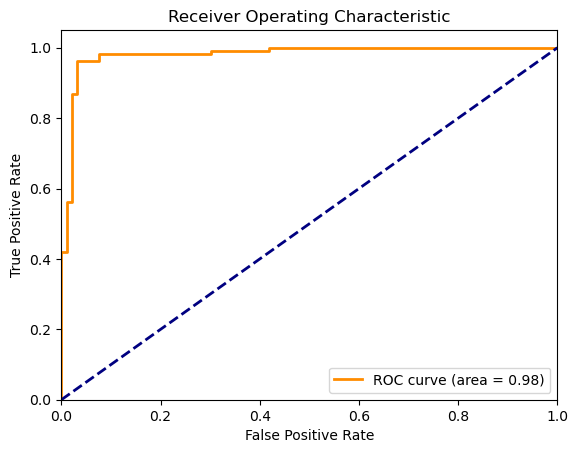

In [ ]:
import matplotlib.pyplot as plt

plt.figure()

# Visualize the Receiver Operating Characteristic (ROC) curve against the random baseline.
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot limits, labels, and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

Choosing the right metric is crucial for evaluating and improving classification models effectively. It's important to consider the business context and the costs associated with different types of errors when deciding which metric to focus on. By understanding the strengths and limitations of each metric, you can develop more robust and reliable classifiers.

## Regression Metrics (Self-Study)

While the previous sections dealt with classification, this block demonstrates how to evaluate Regression models, where the goal is to predict continuous quantities (like price, temperature, or distance) rather than categories.

We define a small set of ground truth values `(y_true)` and model predictions `(y_pred)` to calculate four standard regression metrics:

**MAE (Mean Absolute Error)**: The average magnitude of errors, treating all errors equally.

**MSE (Mean Squared Error)**: The average of squared errors. It penalizes larger errors more severely than MAE.

**RMSE (Root Mean Squared Error)**: The square root of MSE. It brings the error unit back to the original unit of the target variable, making it easier to interpret.

**R² (Coefficient of Determination)**: Represents the proportion of variance in the dependent variable that is predictable from the independent variable(s). A score of 1.0 indicates perfect prediction.

In [529]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define ground truth values and corresponding model predictions
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]

# Calculate error metrics
mae = mean_absolute_error(y_true, y_pred)      # Average absolute difference
mse = mean_squared_error(y_true, y_pred)       # Average squared difference
rmse = np.sqrt(mse)                            # Standard deviation of the prediction errors
r2 = r2_score(y_true, y_pred)                  # Goodness of fit (1.0 is perfect)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

Mean Absolute Error (MAE): 0.50
Mean Squared Error (MSE): 0.38
Root Mean Squared Error (RMSE): 0.61
R-squared (R^2): 0.95



### Mean Squared Error (MSE)

Mean Squared Error is the average of the squared differences between the predicted values and the actual values. It gives a higher weight to larger errors.

$$ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

**Interpretation**

- MSE is sensitive to outliers.
- Larger errors have a disproportionately large effect on MSE, making it useful when large errors are particularly undesirable.

### Mean Absolute Error (MAE)

Mean Absolute Error is the average of the absolute differences between the predicted values and the actual values. It gives an idea of how wrong the predictions were.

$$ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| $$

**Interpretation**

- MAE is easy to understand and calculate.
- It measures the average magnitude of errors in a set of predictions, without considering their direction.

### Root Mean Squared Error (RMSE)

Root Mean Squared Error is the square root of the mean squared error. It is one of the most widely used metrics for regression tasks.

$$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

**Interpretation**

- RMSE is in the same units as the response variable.
- Like MSE, it gives a higher weight to larger errors.

### R-squared (Coefficient of Determination)

R-squared is a statistical measure that represents the proportion of the variance for the dependent variable that's explained by the independent variables in a regression model.

$$ R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} $$

**Interpretation**

- R-squared values range from 0 to 1.
- A higher R-squared value indicates a better fit between prediction and actual value.

### Adjusted R-squared

Adjusted R-squared is a modified version of R-squared that has been adjusted for the number of predictors in the model.

$$ \text{Adjusted } R^2 = 1 - \frac{(1-R^2)(n-1)}{n-p-1} $$

where:
- $ n $ is the number of observations
- $ p $ is the number of predictors

**Interpretation**

- Adjusted R-squared penalizes for adding predictors that do not improve the model.
- It's used to compare the explanatory power of regression models that contain different numbers of predictors.